# Telco Report

## Goal:
- Discover potential drivers of churn.
- Construct a machine learning classification model that can accurately predict churn.

## Imports:

In [3]:
# import personal modules
import acquire
import prepare
import explore
import model

# import external libraries
import pandas as pd
import numpy as np

# Handle warnings
import warnings
warnings.simplefilter('ignore')

## Acquire
The Telco dataset is pulled from the Codeup MySQL database, or from a local file if it exists.

Uncleaned, the data is messy and inconsistent, such as <u>senior_citizen</u> being formatted in 0's and 1's while other boolean values are 'Yes' and 'No'. Some variables are repetitive, unnecessary, or can be condensed. <u>tenure</u> does not indicate a time frame. <u>internet_service_type</u> holds *nulls*, and <u>total_charges</u> is formatted as an object when it clearly should be a numeric.

In [5]:
# acquire data
raw_telco = acquire.get_telco_data()
acquire.df_info(raw_telco,samples=3)

Reading from file...


,nunique,dtypes,isnull,346,3544,2371
payment_type_id,4,int64,0,4,1,1
internet_service_type_id,3,int64,0,1,2,2
contract_type_id,3,int64,0,3,1,1
customer_id,7043,object,0,0513-RBGPE,5022-KVDQT,3398-FSHON
gender,2,object,0,Male,Male,Female
senior_citizen,2,int64,0,0,0,1
partner,2,object,0,Yes,No,No
dependents,2,object,0,Yes,No,No
tenure,73,int64,0,37,27,12
phone_service,2,object,0,Yes,Yes,Yes


## Prepare
Having used a personally-developed function to get an overall picture of the data, I developed a function to prepare the data accordingly.

Preparation actions made:
- Renamed columns:
    - Renamed <u>tenure</u> to <u>tenure_months</u> for clarity
    - Renamed <u>partner</u> to <u>married</u>
    - Renamed <u>dependents</u> to <u>children</u>
- Combined columns
    - Combined <u>phone_service</u> and <u>multiple_lines</u> to <u>phone_lines</u>
    - Combined <u>online_security</u> and <u>device_protection</u> to <u>protection</u>
    - Combined <u>streaming_movies</u> and <u>streaming_tv</u> to <u>streaming</u>
    - Combined <u>tech_support</u> and <u>online_backup</u> to <u>support</u>
- Set <u>customer_id</u> as the index
- Remapped <u>senior_citizen</u> values to 'Yes' and 'No'
- Filled *null* values in <u>internet_service_type</u> with 'None'
- Converted <u>total_charges</u> to float

<u></u>

In [7]:
# prepare data
telco = prepare.prep_telco(raw_telco)

In [8]:
# split data
tvt_set = train,validate,test = prepare.split_df(telco,'churn')
acquire.df_info(train,samples=3)

,nunique,dtypes,isnull,0203-HHYIJ,5339-PXDVH,5996-EBTKM
gender,2,object,0,Male,Male,Female
senior_citizen,2,object,0,No,No,No
married,2,object,0,No,No,Yes
children,2,object,0,No,No,Yes
tenure_months,73,int64,0,25,4,67
paperless_billing,2,object,0,No,No,Yes
monthly_charges,1374,float64,0,25.3,90.65,69.9
total_charges,4006,float64,0,676.35,367.95,4615.9
churn,2,object,0,Yes,No,No
contract_type,3,object,0,One year,Month-to-month,Two year


### Data Dictionary:
| Variable | Description |
| -------- | ----------- |
| index | Customer_ID, the identification code associated with each customer |
| gender | Male or Female, the gender of each customer |
| senior_citizen | Yes or No, whether or not the customer is a senior citizen |
| married | Yes or No, whether or not the customer has a spouse |
| children | Yes or No, whether or not the customer has children |
| tenure_months | Integer, the amount of months the customer has been with Telco |
| paperless_billing | Yes or No, whether a customer has signed up for paperless billing |
| monthly_charges | Float, each customer's monthly charge |
| total_charges | Float, each customer's total charge to current date |
| churn (target) | Yes or No, whether a customer has ended his or her contract with Telco |
| contract_type | The type of contract the customer has with Telco (Month-to-Month, 1 Year, or 2 Year) |
| internet_service_type | The type of internet the customer has with Telco (Fiber, DSL, or none) |
| payment_type | How a customer pays for his or her service |
| streaming | Details on which streaming services a customer may be subscribed to |
| phone_lines | Details on a customer's phone service |
| protection | Details on which online protection services a customer may have |
| support | Details on which online support services a customer may have |
| Additional features | Encoded values for categorical data for the sake of modeling |

## Explore

### What contract types cause higher churn?

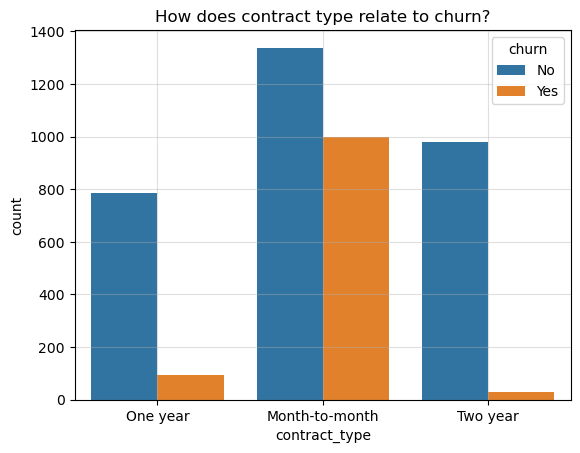

H_0: Churn is independent of contract type.
H_a: Churn is not independent of contract type.

We reject the null hypothesis.
 Our p-value is 8.298049251133243e-156 
 Our statistic value is 714.1745080997528


In [12]:
# explore churn in relation to contract_types
explore.contract_churn(train)

Based on our findings, individuals tend to churn more based on month-to-month contracts. This can be expected since customers with month-to-month contracts may prefer the flexibility to switch providers without penalties, making them more responsive to competitive offers, service dissatisfaction, or changing needs. This contract type often attracts customers seeking short-term solutions, leading to higher churn rates compared to longer-term contracts.

### What is the relationship between monthly charges and churn?

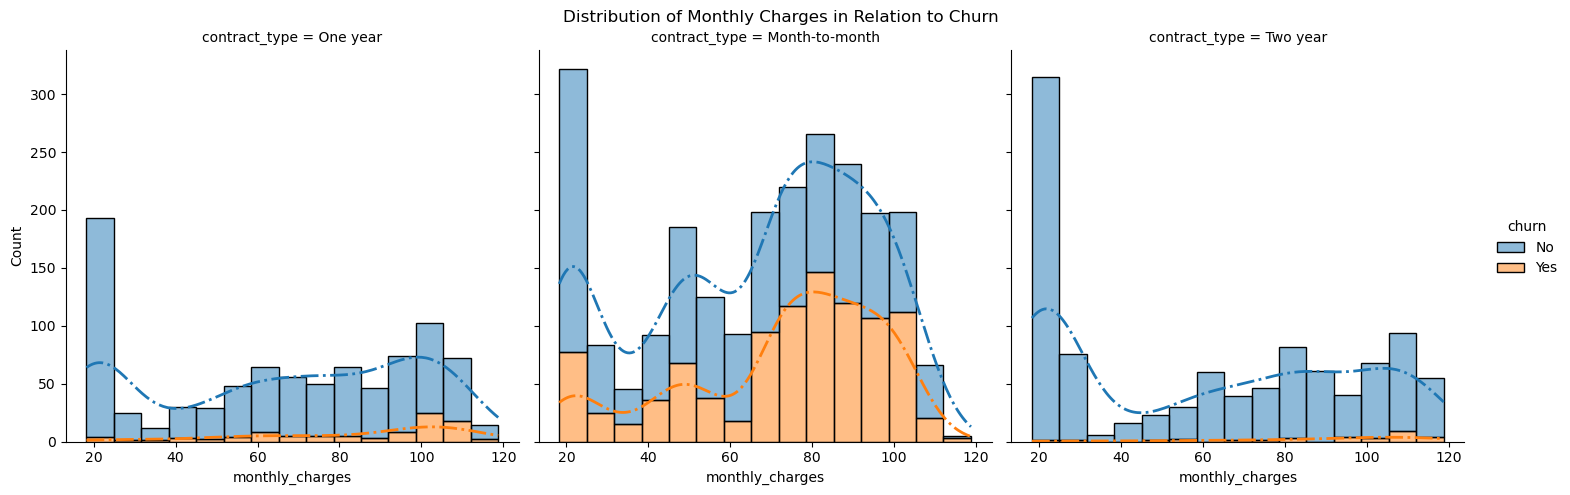

Running Shapiro test for normalcy:
H_0: Monthly charges is distributed normally.
H_a: Monthly charges is not distributed normally.

We reject the null hypothesis.
 Our p-value is 5.647232811229013e-43 
 Our statistic value is 0.9185670018196106

Running Mann-Whitney means test:
H_0: There is no difference between the monthly charges of customers who have churned and those who have not.
H_a: There is a difference between the monthly charges of customers who have churned and those who have not.

We reject the null hypothesis.
 Our p-value is 9.83259830397179e-30 
 Our statistic value is 2136241.0


In [15]:
# explore monthly charges in relation to churn
explore.month_charges_churn(train)

When exploring the monthly charges and churn, I discovered that customers with month-to-month contracts tend to experience significantly higher charges in comparison to customers with other contracts.

### Does internet (or lack of) affect churn?

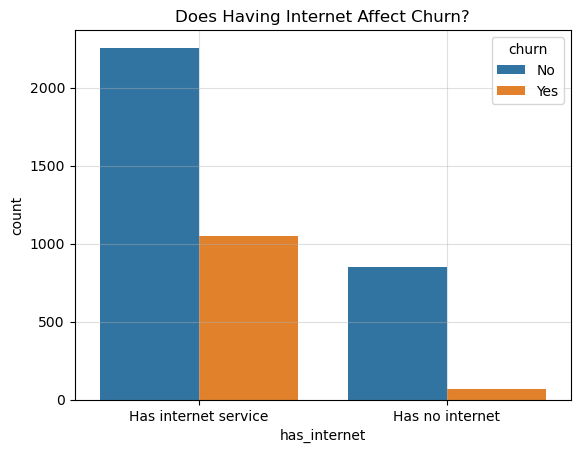

H_0: Churn and having internet are independent.
H_a: Churn and having internet are not independent.

We reject the null hypothesis.
 Our p-value is 1.9838411045748552e-48 
 Our statistic value is 213.85198688891234


In [17]:
# explore having internet in relation to churn
explore.internet_churn(train)

### Do any of the internet services have a particular impact on churn?

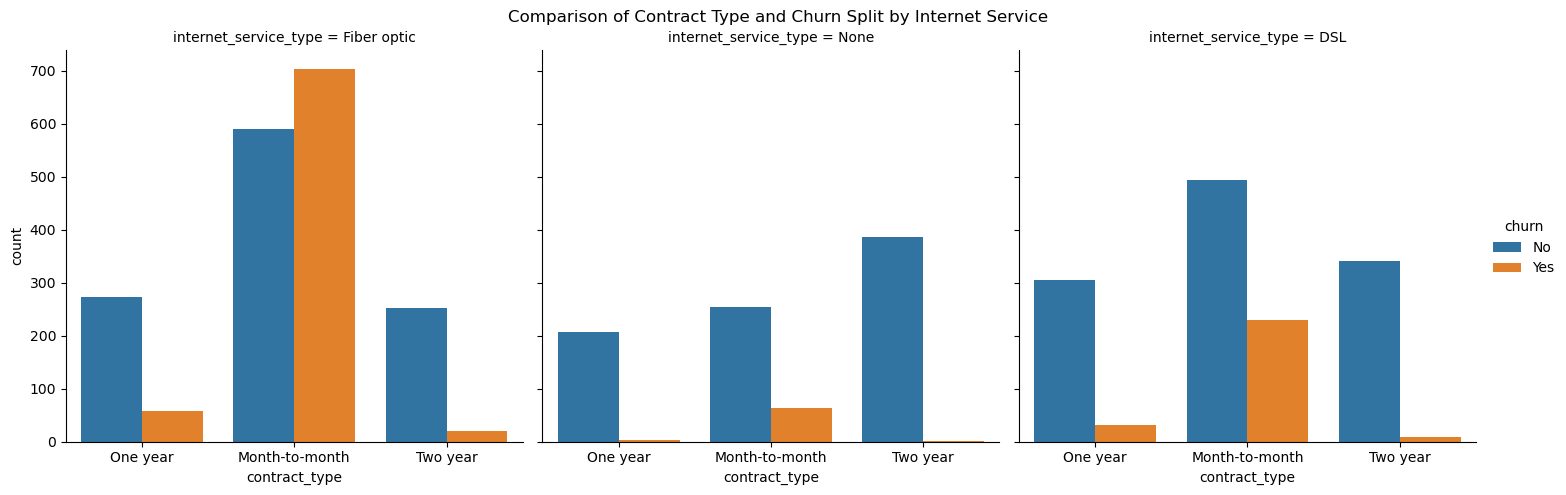

In [19]:
# explore type of internet in contrast with contract type and churn
explore.churn_contract_internet(train)

My analysis of internet service found that customers who have internet are far more likely to churn than those without. Exploring this connection in conjunction with contract types shows that of the monthly customers churn most from the fiber optic service.

## Summary of findings
- Monthly charges play a significant role in whether a customer will churn or not.
- There is a greater proportion of churn from customers with internet as opposed to those without internet.
- Monthly customers churn most from fiber optic internet.

## Pre-Process
Before modeling, the data must be further processed and encoded.

*Xy_sets()* is a function that encodes data sets and splits them into their respective X and y sets. The function takes the train, validate, and test sets as a list, along with a target variable. After encoding and splitting the sets, it returns two lists: X_set and y_set, which can be iterated through for the train, validate, and test sets.

| Set | Equivalent to |
| --- | ------------- |
| tvt_set[0] | train |
| tvt_set[1] | validate |
| tvt_set[2] | test |
| X_set[0] | X_train |
| y_set[0] | y_train |
| X_set[1] | X_validate |
| y_set[1] | y_validate |
| X_set[2] | X_test |
| y_set[2] | y_test |

In [64]:
# pre-process data for models
X_set,y_set = model.Xy_sets(tvt_set,'churn')
acquire.df_info(X_set[0])

,nunique,dtypes,isnull,8327-LZKAS
tenure_months,73,int64,0,43.00
monthly_charges,1374,float64,0,107.55
total_charges,4006,float64,0,4533.90
gender_is_Male,2,float64,0,0.00
senior_citizen_is_Yes,2,float64,0,1.00
married_is_Yes,2,float64,0,1.00
children_is_Yes,2,float64,0,0.00
paperless_billing_is_Yes,2,float64,0,1.00
contract_type_is_One year,2,float64,0,1.00
contract_type_is_Two year,2,float64,0,0.00


During encoding, all variables of object type are split on their respective values. Please note that not all values are necessarily included during this process, but the models are still able to predict based on their *lack of inclusion*.

## Model
For the modeling stage, I built four separate functions to help me evaluate the metrics of each value. Each function returns a dataframe with the type of model used, the model itself, the training accuracy, the validate accuracy, the hyperparameters used, the difference between the training and validate accuracies, and the mean of each model's accuracies.

Each function is also able to plot the difference between the training and validate accuracies to aid in developing filter criteria.

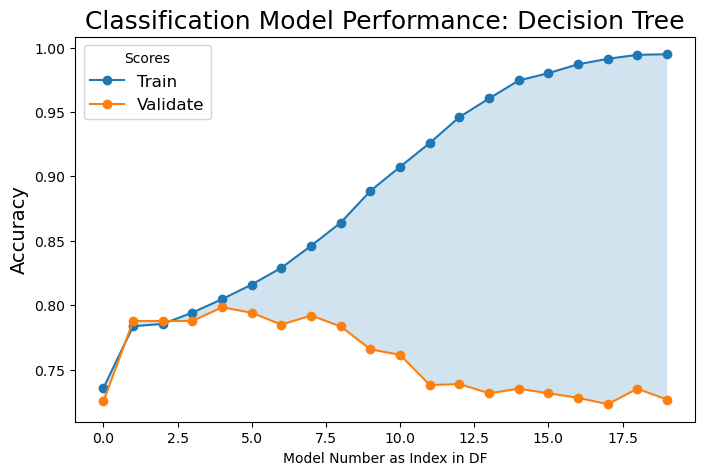

In [70]:
# build decision tree models
dt_models = model.dt_modeling(X_set,y_set,plot=True)

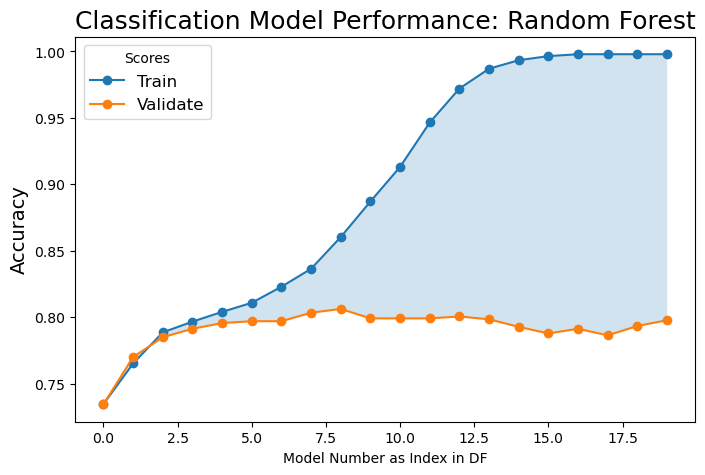

In [72]:
# build random forest models
rf_models = model.rf_modeling(X_set,y_set,plot=True)

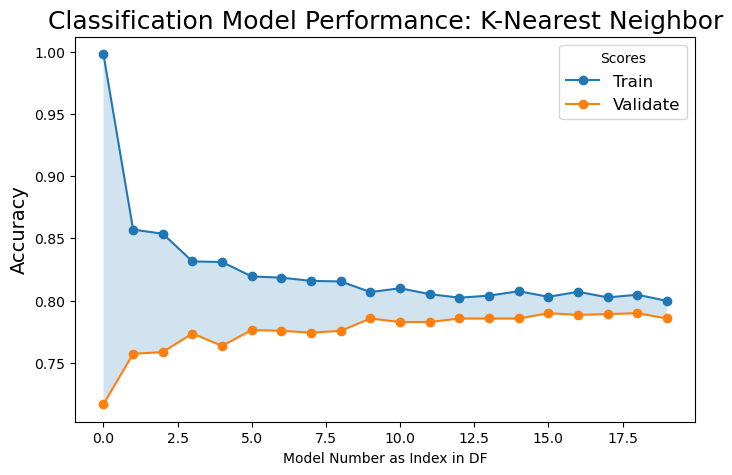

In [73]:
# build k-nearest neighbors models
knn_models = model.knn_modeling(X_set,y_set,plot=True)

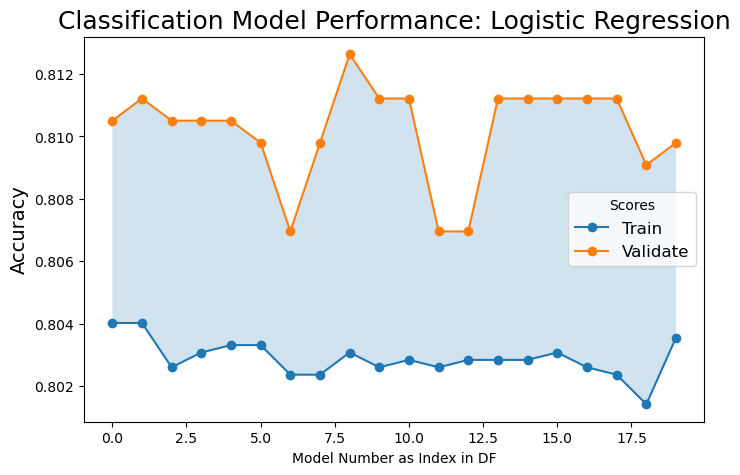

In [74]:
# build logistic regression models
lr_models = model.lr_modeling(X_set,y_set,plot=True)

I created an additional two functions to filter my models based on the following criteria:

For metrics_filter():
- Drop the model if its validation accuracy is below the training set's baseline
- Drop the model if its difference is greater than the mean of all differences in the set of models
- Drop the model if its average is less than the mean of all averages in the set of models
- Drop the model if its validate score is less than the mean of all validate scores in the set of models

for final_models:
- Drop the model if it does not exceed the validate score cutoff (default is 0.8)
- Drop the model if it does not exceed the average score cutoff (default is 0.8)
- Return only the top 3 remaining models

In [24]:
# Filter models
dt_models = model.metrics_filter(dt_models,y_set[0])
rf_models = model.metrics_filter(rf_models,y_set[0])
knn_models = model.metrics_filter(knn_models,y_set[0])
lr_models = model.metrics_filter(lr_models,y_set[0])

In [25]:
# Select final best models
finals = model.final_models([dt_models,rf_models,knn_models,lr_models])
finals

,type,model,train_acc,validate_acc,hyperparameters,difference,average
2,RandomForest,"(DecisionTreeClassifier(max_depth=8, max_features='sqrt', random_state=843828734), Dec...",0.836450,0.803407,max_depth=8,0.033043,0.819928
3,RandomForest,"(DecisionTreeClassifier(max_depth=9, max_features='sqrt', random_state=843828734), Dec...",0.860355,0.806246,max_depth=9,0.054109,0.833300
8,LogisticRegression,"LogisticRegression(C=12, random_state=123)",0.803077,0.812633,C=12,-0.009556,0.807855


From here I manually selected the RandomForest model with a max_depth of 8 because it had the highest accuracies with the lowest difference.

In [26]:
# Isolate the best model
best_model = finals.iloc[0,1]
best_model

RandomForestClassifier(max_depth=8, random_state=123)

In [27]:
# Run final test
best_model.score(X_set[2],y_set[2])

0.8055358410220014

After testing the model, I created a CSV to hold the probabilities and predictions of the model.

In [28]:
# Generate CSV of overall model predictions
pd.DataFrame({
    'Customer_ID':X_set[2].index,
    # 'actual':y_set[2],
    'Probability of Churn':[prob[1] for prob in best_model.predict_proba(X_set[2])],
    'Prediction of Churn':np.where(best_model.predict(X_set[2]) == 'Yes', 1, 0)
}).to_csv('predictions.csv',index=False)

## Conclusions